# Load libraries

In [51]:
import torch
import torch.nn as nn
from torchvision.transforms import transforms
import numpy as np
from torch.autograd import Variable
from torchvision.models import squeezenet1_1
import torch.functional as F
from io import open
import os
from PIL import Image
import pathlib
import glob
import cv2

# Setup

In [52]:
train_path='./seg_train/seg_train'
pred_path='./seg_pred/seg_pred'

In [53]:
# Categories
root=pathlib.Path(train_path)
classes=sorted([j.name.split('/')[-1] for j in root.iterdir()])

# CNN Network

In [54]:
class ConvNet(nn.Module):
    def __init__(self,num_classes=6):
        super(ConvNet,self).__init__()
        
        # Output size after convolution filter
        # ((w-f+2P)/s) +1
        
        # Input shape= (256,3,150,150)
        
        self.conv1=nn.Conv2d(in_channels=3, out_channels=12, kernel_size=3, stride=1, padding=1)
        # Shape= (256,12,150,150)
        self.bn1=nn.BatchNorm2d(num_features=12)
        # Shape= (256,12,150,150)
        self.relu1=nn.ReLU()
        # Shape= (256,12,150,150)
        
        self.pool=nn.MaxPool2d(kernel_size=2)
        # Reduce the image size be factor 2
        # Shape= (256,12,75,75)
        
        self.conv2=nn.Conv2d(in_channels=12, out_channels=20, kernel_size=3, stride=1, padding=1)
        # Shape= (256,20,75,75)
        self.relu2=nn.ReLU()
        # Shape= (256,20,75,75)
        
        self.conv3=nn.Conv2d(in_channels=20, out_channels=32, kernel_size=3, stride=1, padding=1)
        # Shape= (256,32,75,75)
        self.bn3=nn.BatchNorm2d(num_features=32)
        # Shape= (256,32,75,75)
        self.relu3=nn.ReLU()
        # Shape= (256,32,75,75)
        
        
        self.fc=nn.Linear(in_features=75 * 75 * 32, out_features=num_classes)
        
        # Feed forward function
         
    def forward(self,input):
        output = self.conv1(input)
        output = self.bn1(output)
        output = self.relu1(output)
              
        output = self.pool(output)
              
        output = self.conv2(output)
        output = self.relu2(output)
              
        output = self.conv3(output)
        output = self.bn3(output)
        output = self.relu3(output)
                
        # Above output will be in matrix form, with shape (256,32,75,75)
            
        output = output.view(-1,32*75*75)
            
        output = self.fc(output)
            
        return output

In [55]:
checkpoint = torch.load('best_checkpoint.model')
model = ConvNet(num_classes=6)
model.load_state_dict(checkpoint)
model.eval()

ConvNet(
  (conv1): Conv2d(3, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(12, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1): ReLU()
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(12, 20, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu2): ReLU()
  (conv3): Conv2d(20, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu3): ReLU()
  (fc): Linear(in_features=180000, out_features=6, bias=True)
)

In [56]:
# Transforms
transformer=transforms.Compose([
    transforms.Resize((150,150)),
    transforms.ToTensor(),  #0-255 to 0-1, numpy to tensors
    transforms.Normalize([0.5,0.5,0.5], # 0-1 to [-1,1] , formula (x-mean)/std
                        [0.5,0.5,0.5])
])

# Prediction function

In [57]:
def prediction(img_path,transformer):
    
    image = Image.open(img_path)
    
    image_tensor = transformer(image).float()
    
    image_tensor = image_tensor.unsqueeze_(0)
    
    if torch.cuda.is_available():
        image_tensor.cuda()
        
    input = Variable(image_tensor)
    
    output = model(input)
    
    index = output.data.numpy().argmax()
    
    pred = classes[index]
    
    return pred

# Results

In [58]:
images_path = glob.glob(pred_path+'/*.jpg')

In [59]:
pred_dict={}

for i in images_path:
    pred_dict[i[i.rfind('/')+1:]] = prediction(i,transformer)

In [60]:
pred_dict

{'seg_pred\\10004.jpg': 'street',
 'seg_pred\\10005.jpg': 'mountain',
 'seg_pred\\10012.jpg': 'street',
 'seg_pred\\10013.jpg': 'mountain',
 'seg_pred\\10017.jpg': 'glacier',
 'seg_pred\\10021.jpg': 'forest',
 'seg_pred\\1003.jpg': 'sea',
 'seg_pred\\10034.jpg': 'glacier',
 'seg_pred\\10038.jpg': 'sea',
 'seg_pred\\10040.jpg': 'street',
 'seg_pred\\10043.jpg': 'sea',
 'seg_pred\\10045.jpg': 'street',
 'seg_pred\\10047.jpg': 'mountain',
 'seg_pred\\10048.jpg': 'buildings',
 'seg_pred\\10052.jpg': 'buildings',
 'seg_pred\\10054.jpg': 'glacier',
 'seg_pred\\10059.jpg': 'forest',
 'seg_pred\\10060.jpg': 'forest',
 'seg_pred\\10066.jpg': 'mountain',
 'seg_pred\\10069.jpg': 'sea',
 'seg_pred\\10073.jpg': 'street',
 'seg_pred\\10079.jpg': 'street',
 'seg_pred\\1008.jpg': 'forest',
 'seg_pred\\10082.jpg': 'street',
 'seg_pred\\10083.jpg': 'buildings',
 'seg_pred\\10090.jpg': 'buildings',
 'seg_pred\\10092.jpg': 'forest',
 'seg_pred\\10096.jpg': 'mountain',
 'seg_pred\\101.jpg': 'glacier',
 'se

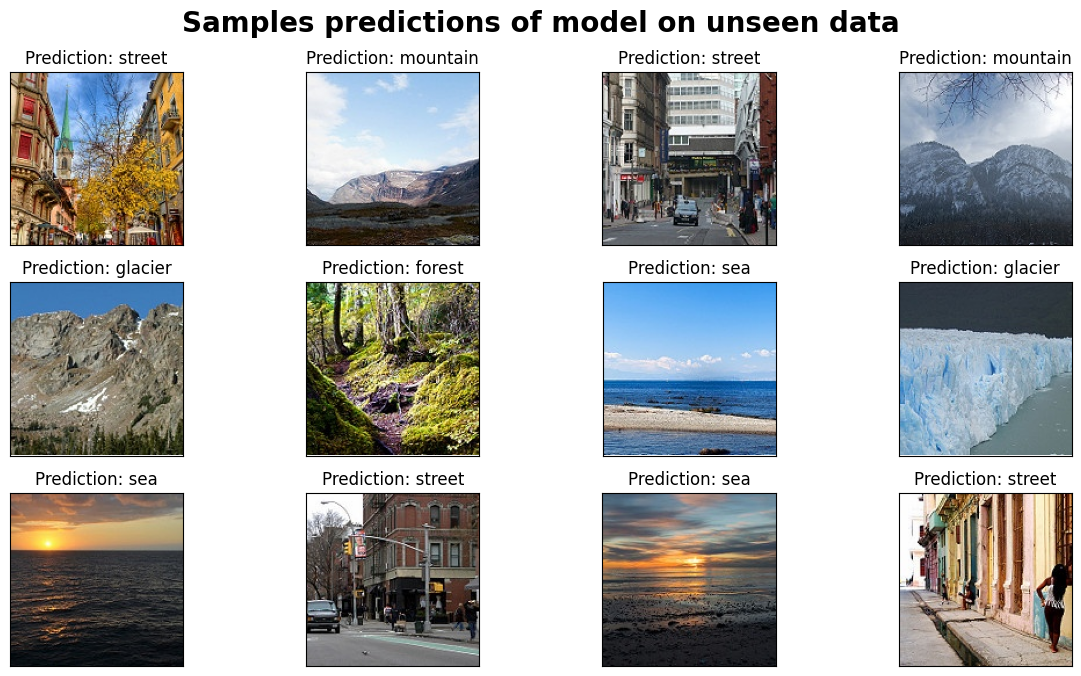

In [61]:
plt.figure(figsize=(12, 9))

for i in range(12):
    plt.subplot(4, 4, i+1)
    img = Image.open(images_path[i])
    plt.imshow(img)
    plt.title("Prediction: " + prediction(images_path[i],transformer))
    plt.xticks([])
    plt.yticks([])

plt.suptitle("Samples predictions of model on unseen data", size=20, weight='bold')
plt.tight_layout()
plt.show()
